<a href="https://colab.research.google.com/github/MattJCR/Practica-DEEP-LEARNING/blob/master/Practica_DEEP_LEARNING_Parte_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importacion de librerias

In [ ]:
import os
import gdown
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.utils.vis_utils import plot_model

# Descargar el modelo

In [ ]:
# Reemplaza YOUR_FILE_ID con el ID del archivo Animals-10.zip en Google Drive
file_id = '13xNMXQ4bkfPyUAqqtIQEdft1YZKH118E'
url = f'https://drive.google.com/uc?id={file_id}'
output = 'Animals-10.zip'

# Descargar el archivo zip desde Google Drive
gdown.download(url, output, quiet=False)

# Descomprimir el archivo zip
with zipfile.ZipFile('Animals-10.zip', 'r') as zip_ref:
    zip_ref.extractall('./Animals-10')

Downloading...
From: https://drive.google.com/uc?id=13xNMXQ4bkfPyUAqqtIQEdft1YZKH118E
To: /content/Animals-10.zip
100%|██████████| 614M/614M [00:08<00:00, 70.6MB/s]


# Definir el ImageDataGenerator y los datos de entrenamiento

In [ ]:
# Definir las dimensiones de las imágenes de entrada
IMG_HEIGHT = 224
IMG_WIDTH = 224

# Ruta del directorio principal de las imágenes
data_dir = './Animals-10/raw-img'

# Leer todas las imágenes y etiquetas
images = []
labels = []
class_names = os.listdir(data_dir)

# Diccionario para traducir las labels
translate = {
    "cane": "dog", 
    "cavallo": "horse", 
    "elefante": "elephant", 
    "farfalla": "butterfly", 
    "gallina": "chicken", 
    "gatto": "cat", 
    "mucca": "cow", 
    "pecora": "sheep", 
    "scoiattolo": "squirrel",
    "ragno": "spider"
}
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    image_files = os.listdir(class_dir)
    for image_file in image_files:
        image_path = os.path.join(class_dir, image_file)
        images.append(image_path)
        # Traduce las etiquetas a inglés y las agrega a la lista labels
        labels.append(translate[class_name])

# Dividir los datos en entrenamiento, validación y prueba
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.25, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.33, random_state=42)

# Crear generador de datos para el conjunto de entrenamiento
train_datagen = ImageDataGenerator(rescale=1.0/255)

# Crear generador de datos para el conjunto de validación
val_datagen = ImageDataGenerator(rescale=1.0/255)

# Crear generador de datos para el conjunto de prueba
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Generar los conjuntos de datos de entrenamiento y prueba a partir de los directorios

In [ ]:
# Generar el conjunto de datos de entrenamiento a partir de las imágenes y etiquetas
train_data = train_datagen.flow_from_dataframe(
    pd.DataFrame({'images': train_images, 'labels': train_labels}),
    x_col='images',
    y_col='labels',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical'
)

# Generar el conjunto de datos de validación a partir de las imágenes y etiquetas
val_data = val_datagen.flow_from_dataframe(
    pd.DataFrame({'images': val_images, 'labels': val_labels}),
    x_col='images',
    y_col='labels',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical'
)

# Generar el conjunto de datos de prueba a partir de las imágenes y etiquetas
test_data = test_datagen.flow_from_dataframe(
    pd.DataFrame({'images': test_images, 'labels': test_labels}),
    x_col='images',
    y_col='labels',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical'
)

Found 13154 validated image filenames belonging to 10 classes.
Found 6480 validated image filenames belonging to 10 classes.
Found 6545 validated image filenames belonging to 10 classes.


# Definimos los callbacks comunes

In [ ]:
# Definir early stopping
early_stop = EarlyStopping(monitor='accuracy', patience=3, mode='max', verbose=0)

# Definir reducción del learning rate
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.75, patience=2, mode='max', verbose=0)

# Crear un objeto ModelCheckpoint para guardar el mejor modelo durante el entrenamiento
checkpointer = ModelCheckpoint(filepath='weights.best.inc.InceptionV3.hdf5', verbose=1, save_best_only=True)

# Importación del modelo InceptionV3 con SGD

In [ ]:
# Importar el modelo InceptionV3
inc_model = InceptionV3(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

print("Número de capas:", len(inc_model.layers))

# Congelar las capas iniciales para que no se entrenen
for layer in inc_model.layers:
    layer.trainable = False

# Agregar capas personalizadas
x = inc_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
predictions = Dense(len(class_names), activation="softmax")(x)  # Asegúrate de tener tantos nodos de salida como clases

# Crear el modelo final
model_ = Model(inputs=inc_model.input, outputs=predictions)

# Compilar el modelo
model_.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# Crear un objeto ModelCheckpoint para guardar el mejor modelo durante el entrenamiento
checkpointer = ModelCheckpoint(filepath='weights.best.inc.InceptionV3.hdf5', verbose=1, save_best_only=True)

plot_model(model_, to_file='model_InceptionV3.png', show_shapes=True, show_layer_names=True)

87910968/87910968 [==============================] - 0s 0us/step
Número de capas: 311


## Entrenar el modelo utilizando fit_generator

In [ ]:
history = model_.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    epochs=10,
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=[early_stop,reduce_lr,checkpointer],
    use_multiprocessing=True
)

Epoch 1/10
411/411 [==============================] - ETA: 0s - loss: 0.4788 - accuracy: 0.8647
Epoch 1: val_loss improved from inf to 0.16822, saving model to weights.best.inc.InceptionV3.hdf5
411/411 [==============================] - 185s 414ms/step - loss: 0.4788 - accuracy: 0.8647 - val_loss: 0.1682 - val_accuracy: 0.9519 - lr: 0.0010
Epoch 2/10
411/411 [==============================] - ETA: 0s - loss: 0.1918 - accuracy: 0.9442
Epoch 2: val_loss improved from 0.16822 to 0.14950, saving model to weights.best.inc.InceptionV3.hdf5
411/411 [==============================] - 168s 408ms/step - loss: 0.1918 - accuracy: 0.9442 - val_loss: 0.1495 - val_accuracy: 0.9539 - lr: 0.0010
Epoch 3/10
411/411 [==============================] - ETA: 0s - loss: 0.1670 - accuracy: 0.9511
Epoch 3: val_loss improved from 0.14950 to 0.14097, saving model to weights.best.inc.InceptionV3.hdf5
411/411 [==============================] - 179s 434ms/step - loss: 0.1670 - accuracy: 0.9511 - val_loss: 0.1410 - 

## Evaluar el modelo InceptionV3 en el conjunto de prueba

In [ ]:
test_loss, test_accuracy = model_.evaluate(test_data, steps=test_data.samples // test_data.batch_size)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

204/204 [==============================] - 23s 112ms/step - loss: 0.1349 - accuracy: 0.9619
Test Loss: 0.13494940102100372
Test Accuracy: 0.9618566036224365


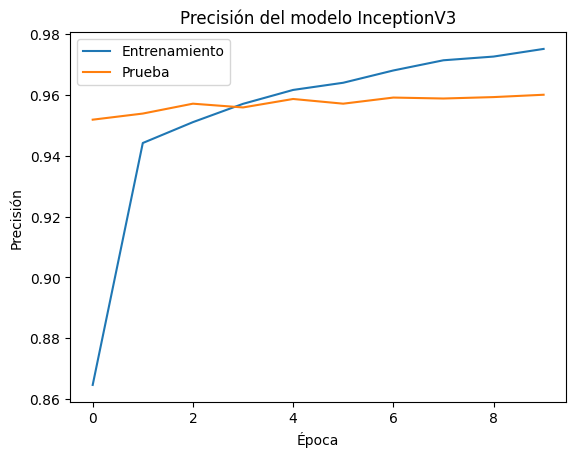

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del modelo InceptionV3')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Prueba'], loc='upper left')
plt.show()

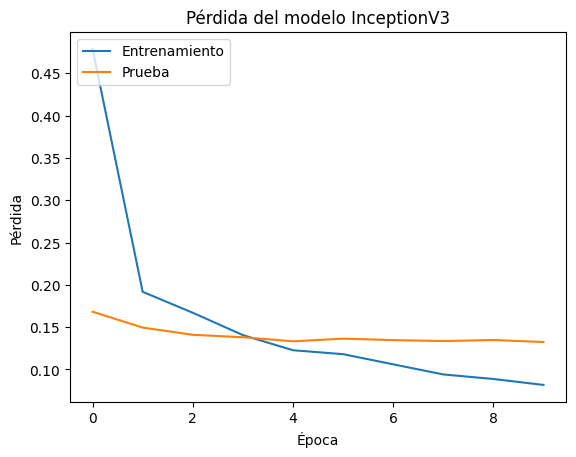

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del modelo InceptionV3')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Prueba'], loc='upper left')
plt.show()

# Importar el modelo ResNet50 con RMSprop

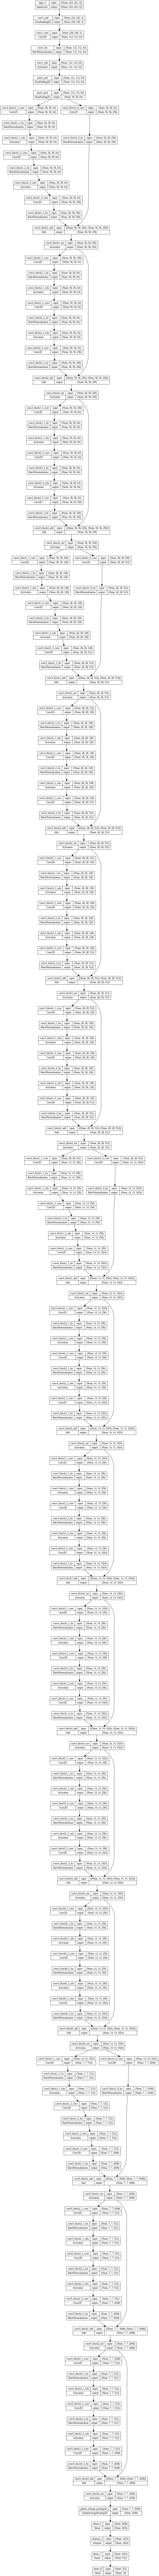

In [ ]:
resnet_model = ResNet50(include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Congelar las capas iniciales para que no se entrenen
for layer in resnet_model.layers:
    layer.trainable = False

# Agregar capas personalizadas
x = resnet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(2048, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
predictions = Dense(len(class_names), activation="softmax")(x)

# Crear el modelo final
model_ = Model(inputs=resnet_model.input, outputs=predictions)

# Compilar el modelo con RMSprop como optimizador
model_.compile(optimizer=RMSprop(learning_rate=0.0001),
               loss='categorical_crossentropy',
               metrics=['accuracy'])

# Crear un objeto ModelCheckpoint para guardar el mejor modelo durante el entrenamiento
checkpointer = ModelCheckpoint(filepath='weights.best.inc.ResNet50.hdf5', verbose=1, save_best_only=True)

plot_model(model_, to_file='model_ResNet50.png', show_shapes=True, show_layer_names=True)

## Entrenar el modelo utilizando fit_generator

In [ ]:
history = model_.fit(
    train_data,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    epochs=10,
    validation_data=val_data,
    validation_steps=val_data.samples // val_data.batch_size,
    callbacks=[early_stop,reduce_lr,checkpointer],
    use_multiprocessing=True
)

Epoch 1/10
411/411 [==============================] - ETA: 0s - loss: 2.1888 - accuracy: 0.2225
Epoch 1: val_loss improved from inf to 2.08541, saving model to weights.best.inc.ResNet50.hdf5
411/411 [==============================] - 134s 313ms/step - loss: 2.1888 - accuracy: 0.2225 - val_loss: 2.0854 - val_accuracy: 0.2797 - lr: 0.0010
Epoch 2/10
411/411 [==============================] - ETA: 0s - loss: 2.0967 - accuracy: 0.2531
Epoch 2: val_loss improved from 2.08541 to 2.02420, saving model to weights.best.inc.ResNet50.hdf5
411/411 [==============================] - 116s 280ms/step - loss: 2.0967 - accuracy: 0.2531 - val_loss: 2.0242 - val_accuracy: 0.2984 - lr: 0.0010
Epoch 3/10
411/411 [==============================] - ETA: 0s - loss: 2.0631 - accuracy: 0.2691
Epoch 3: val_loss improved from 2.02420 to 2.00293, saving model to weights.best.inc.ResNet50.hdf5
411/411 [==============================] - 135s 328ms/step - loss: 2.0631 - accuracy: 0.2691 - val_loss: 2.0029 - val_accur

## Evaluar el modelo ResNet50 en el conjunto de prueba

In [ ]:
test_loss, test_accuracy = model_.evaluate(test_data, steps=test_data.samples // test_data.batch_size)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

204/204 [==============================] - 27s 131ms/step - loss: 1.8626 - accuracy: 0.3439
Test Loss: 1.8626344203948975
Test Accuracy: 0.34390318393707275


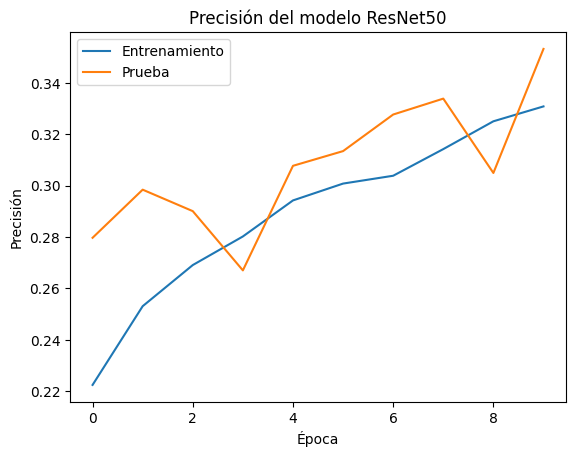

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del modelo ResNet50')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Prueba'], loc='upper left')
plt.show()

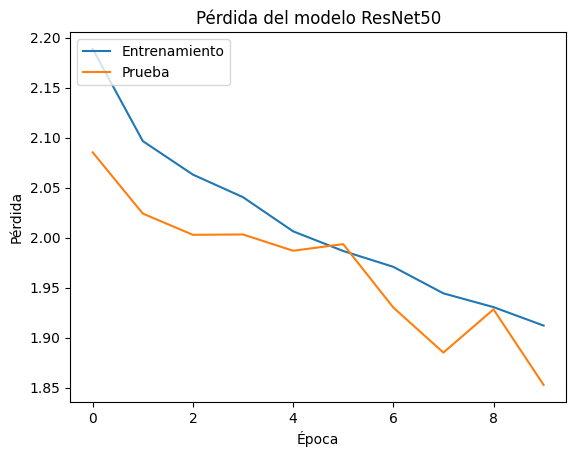

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del modelo ResNet50')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Prueba'], loc='upper left')
plt.show()